# Machine Learning Trading Bot

In [1]:
# Imports Libraries
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

#### Import the OHLCV dataset.

In [2]:
# Import the OHLCV dataset into a Pandas Dataframe
ohlcv_df = pd.read_csv(
    Path("./Resources/emerging_markets_ohlcv.csv"), 
    index_col='date', 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
ohlcv_df.head()

,open,high,low,close,volume
date,,,,,
2015-01-21 09:30:00,23.83,23.83,23.83,23.83,100
2015-01-21 11:00:00,23.98,23.98,23.98,23.98,100
2015-01-22 15:00:00,24.42,24.42,24.42,24.42,100
2015-01-22 15:15:00,24.42,24.44,24.42,24.44,200
2015-01-22 15:30:00,24.46,24.46,24.46,24.46,200


In [3]:
# Filter the date index and close columns
signals_df = ohlcv_df.loc[:, ["close"]]

# Use the pct_change function to generate returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns
date,,
2015-01-21 11:00:00,23.98,0.006295
2015-01-22 15:00:00,24.42,0.018349
2015-01-22 15:15:00,24.44,0.000819
2015-01-22 15:30:00,24.46,0.000818
2015-01-26 12:30:00,24.33,-0.005315


,close,Actual Returns
date,,
2021-01-22 09:30:00,33.27,-0.006866
2021-01-22 11:30:00,33.35,0.002405
2021-01-22 13:45:00,33.42,0.002099
2021-01-22 14:30:00,33.47,0.001496
2021-01-22 15:45:00,33.44,-0.000896


#### Generate trading signals using short- and long-window SMA values. 

In [4]:
# Set the short window and long window
short_window = 48
long_window = 101

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2015-04-02 15:00:00,24.92,0.000000,24.418958,24.327327
2015-04-02 15:15:00,24.94,0.000803,24.423958,24.336832
2015-04-02 15:30:00,24.95,0.000401,24.429583,24.342079
2015-04-02 15:45:00,24.98,0.001202,24.453958,24.347426
2015-04-06 09:30:00,25.16,0.007206,24.481667,24.354356


,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2021-01-22 09:30:00,33.27,-0.006866,31.263125,30.389158
2021-01-22 11:30:00,33.35,0.002405,31.328542,30.431337
2021-01-22 13:45:00,33.42,0.002099,31.394375,30.473911
2021-01-22 14:30:00,33.47,0.001496,31.461250,30.516980
2021-01-22 15:45:00,33.44,-0.000896,31.528542,30.559653


In [5]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2015-04-02 15:00:00,24.92,0.000000,24.418958,24.327327,1.0
2015-04-02 15:15:00,24.94,0.000803,24.423958,24.336832,1.0
2015-04-02 15:30:00,24.95,0.000401,24.429583,24.342079,1.0
2015-04-02 15:45:00,24.98,0.001202,24.453958,24.347426,1.0
2015-04-06 09:30:00,25.16,0.007206,24.481667,24.354356,1.0


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2021-01-22 09:30:00,33.27,-0.006866,31.263125,30.389158,-1.0
2021-01-22 11:30:00,33.35,0.002405,31.328542,30.431337,1.0
2021-01-22 13:45:00,33.42,0.002099,31.394375,30.473911,1.0
2021-01-22 14:30:00,33.47,0.001496,31.461250,30.516980,1.0
2021-01-22 15:45:00,33.44,-0.000896,31.528542,30.559653,-1.0


In [6]:
signals_df['Signal'].value_counts()

 1.0    2367
-1.0    1855
Name: Signal, dtype: int64

In [7]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2015-04-02 15:00:00,24.92,0.000000,24.418958,24.327327,1.0,NaN
2015-04-02 15:15:00,24.94,0.000803,24.423958,24.336832,1.0,0.000803
2015-04-02 15:30:00,24.95,0.000401,24.429583,24.342079,1.0,0.000401
2015-04-02 15:45:00,24.98,0.001202,24.453958,24.347426,1.0,0.001202
2015-04-06 09:30:00,25.16,0.007206,24.481667,24.354356,1.0,0.007206


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2021-01-22 09:30:00,33.27,-0.006866,31.263125,30.389158,-1.0,-0.006866
2021-01-22 11:30:00,33.35,0.002405,31.328542,30.431337,1.0,-0.002405
2021-01-22 13:45:00,33.42,0.002099,31.394375,30.473911,1.0,0.002099
2021-01-22 14:30:00,33.47,0.001496,31.461250,30.516980,1.0,0.001496
2021-01-22 15:45:00,33.44,-0.000896,31.528542,30.559653,-1.0,-0.000896


<Axes: xlabel='date'>

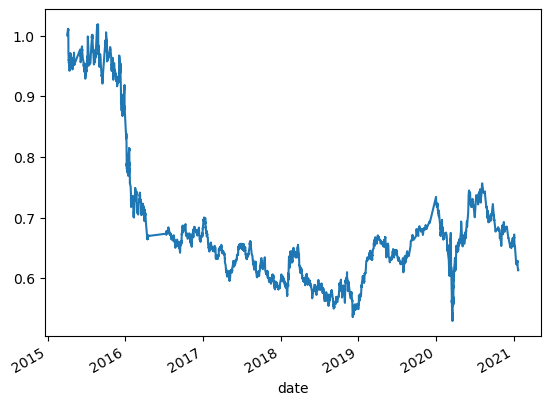

In [8]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

#### Split the data into training and testing datasets.

In [9]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:15:00,24.418958,24.327327
2015-04-02 15:30:00,24.423958,24.336832
2015-04-02 15:45:00,24.429583,24.342079
2015-04-06 09:30:00,24.453958,24.347426
2015-04-06 09:45:00,24.481667,24.354356


In [10]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
y.value_counts()

 1.0    2367
-1.0    1855
Name: Signal, dtype: int64

In [11]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2015-04-02 15:15:00


In [12]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=6)

# Display the training end date
print(training_end)

2015-10-02 15:15:00


In [13]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:15:00,24.418958,24.327327
2015-04-02 15:30:00,24.423958,24.336832
2015-04-02 15:45:00,24.429583,24.342079
2015-04-06 09:30:00,24.453958,24.347426
2015-04-06 09:45:00,24.481667,24.354356


In [14]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_test.head()

,SMA_Fast,SMA_Slow
date,,
2015-10-05 09:45:00,21.218937,21.575733
2015-10-05 11:30:00,21.223938,21.565634
2015-10-05 13:15:00,21.228312,21.556822
2015-10-05 14:30:00,21.234771,21.544941
2015-10-05 14:45:00,21.242062,21.533257


### Standardize the Data

In [15]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

#### Using Machine Learning Into a Trading Strategy

In [16]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model using the scaled training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred[:10]


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### Review the classification report associated with the `SVC` model predictions. 

In [17]:
# classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)


              precision    recall  f1-score   support

        -1.0       0.50      0.00      0.00      1732
         1.0       0.56      1.00      0.72      2211

    accuracy                           0.56      3943
   macro avg       0.53      0.50      0.36      3943
weighted avg       0.53      0.56      0.40      3943



#### Create a predictions DataFrame to compare the Actual and Predicted Returns

In [18]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = (predictions_df['Actual Returns'] * predictions_df["Predicted"])

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())
display(predictions_df[predictions_df['Predicted']== -1])

,Predicted,Actual Returns,Strategy Returns
date,,,
2015-10-05 09:45:00,1.0,0.013532,0.013532
2015-10-05 11:30:00,1.0,0.002302,0.002302
2015-10-05 13:15:00,1.0,-0.000919,-0.000919
2015-10-05 14:30:00,1.0,0.000920,0.000920
2015-10-05 14:45:00,1.0,0.002756,0.002756


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-01-22 09:30:00,1.0,-0.006866,-0.006866
2021-01-22 11:30:00,1.0,0.002405,0.002405
2021-01-22 13:45:00,1.0,0.002099,0.002099
2021-01-22 14:30:00,1.0,0.001496,0.001496
2021-01-22 15:45:00,1.0,-0.000896,-0.000896


,Predicted,Actual Returns,Strategy Returns
date,,,
2020-03-13 15:45:00,-1.0,0.017130,-0.017130
2020-03-16 11:15:00,-1.0,-0.066454,0.066454
2020-03-16 11:30:00,-1.0,-0.006826,0.006826
2020-03-16 12:00:00,-1.0,0.008346,-0.008346
2020-03-16 12:15:00,-1.0,-0.007790,0.007790
2020-03-16 12:30:00,-1.0,0.002453,-0.002453


### Step 7: Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

In [19]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df[['Actual Returns','Strategy Returns']]).cumprod().hvplot()


:NdOverlay   [Variable]
   :Curve   [date]   (value)

---

## Tune the Baseline Trading Algorithm

**_Observation1:_** when training window is increased from 3 months to 10 months we observed a slight increase of 1% in accuracy, 1% increase for +1 signal in precision recall and 1% decrease for -1 signal whereas upon decreaseing the training window by 1 month there is a slight decrease of 2% in accuracy, no change in recall values but decrease in precision for -1 signal.
However we see maximum strategy returns(of 38.7%) with 3 months training window then compared to 10 or 1 months
**with 6 months training window our strategy returns reach maximum 73.57 where actual retrns are 56.04**

**_Observation2:_** When we increasing both of the SMA windows-> slow window= 48(from 4) and fast window-> 101(from 100) with training period same as 3 months, strategy returns traced actual returns initially then ended greater than actual return after march 2020. Also recall for signal = 1 reached 100% from 96%

---

## Evaluate using a New Machine Learning Classifier - AdaBoost
 

#### Import a new classifier, such as `AdaBoost`(For the full list of classifiers that can be used, refer to the [Supervised learning page](https://scikit-learn.org/stable/supervised_learning.html) in the scikit-learn documentation.)

In [20]:
# Import a new classifier from SKLearn
from sklearn.ensemble import AdaBoostClassifier

# Initiate the model instance
clf = AdaBoostClassifier(n_estimators=100)


#### fit another model with the new classifier using the original training data as the baseline model.

In [21]:
# Fit the model using the training data
#model = 
clf.fit(X_train, y_train)

# Use the testing dataset to generate the predictions for the new model
ada_pred = clf.predict(X_test)

# Review the model's predicted values
ada_pred[:10]


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### Backtest the new model to evaluate its performance. 

In [22]:
# Use a classification report to evaluate the model using the predictions and testing data
ada_testing_report = classification_report(y_test, ada_pred)

# Print the classification report
print(ada_testing_report)


              precision    recall  f1-score   support

        -1.0       0.45      0.52      0.48      1732
         1.0       0.57      0.50      0.53      2211

    accuracy                           0.51      3943
   macro avg       0.51      0.51      0.50      3943
weighted avg       0.51      0.51      0.51      3943



In [23]:
# Create a predictions DataFrame
ada_predictions_df = pd.DataFrame(index=X_test.index)

# Add the ADABoost model predictions to the DataFrame
ada_predictions_df['Predicted'] = ada_pred

# Add the actual returns to the DataFrame
ada_predictions_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
ada_predictions_df['Strategy Returns'] = (predictions_df['Actual Returns'] * predictions_df["Predicted"])

# Review the DataFrame
display(ada_predictions_df.head())
display(ada_predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
date,,,
2015-10-05 09:45:00,1.0,0.013532,0.013532
2015-10-05 11:30:00,1.0,0.002302,0.002302
2015-10-05 13:15:00,1.0,-0.000919,-0.000919
2015-10-05 14:30:00,1.0,0.000920,0.000920
2015-10-05 14:45:00,1.0,0.002756,0.002756


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-01-22 09:30:00,-1.0,-0.006866,-0.006866
2021-01-22 11:30:00,-1.0,0.002405,0.002405
2021-01-22 13:45:00,-1.0,0.002099,0.002099
2021-01-22 14:30:00,-1.0,0.001496,0.001496
2021-01-22 15:45:00,-1.0,-0.000896,-0.000896


<Axes: xlabel='date'>

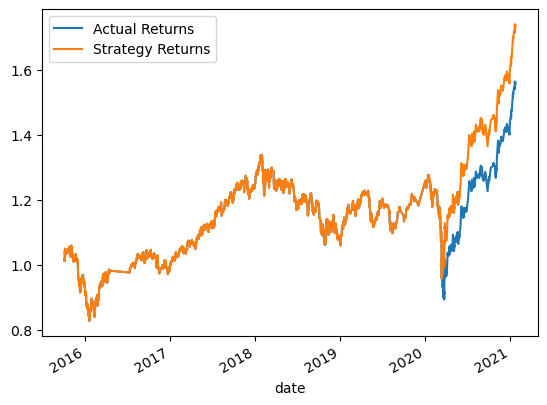

In [24]:
# Plot the actual returns versus the strategy returns
(1 + ada_predictions_df[['Actual Returns','Strategy Returns']]).cumprod().plot()

In [25]:
total_return_ada = round(((((ada_predictions_df['Strategy Returns']+1).cumprod())[-1]) -1)* 100, 2)
total_return_ada

73.57

In [26]:
total_return_svm = round(((((predictions_df['Strategy Returns']+1).cumprod())[-1]) -1)* 100, 2)
total_return_svm

73.57

In [27]:
total_act_return_svm = round(((((predictions_df['Actual Returns']+1).cumprod())[-1]) -1)* 100, 2)
total_act_return_svm

56.04